## Sampling large Datasets
In data processing, a great deal of computing involves analysing large amounts of text mixed with numerical data.  This is what Spark is particularly suited for. Sampling is an essential pre-processing for machine leanring or related issue for 

### Amazon dataset
The file Amazon_xx.inter comprising the ratings of users over the items.
Each record/line in the file has the following fields: user_id, item_id, rating and timestamp.

* user_id: the id of the users and its type is token. 
* item_id: the id of the items and its type is token.
* rating: the rating of the users over the item, and its type is float.
* timestamp: the UNIX time of the interaction, and its type is float.

The file Amazon_xx.item comprising the attributes of the items.
Each record/line in the file has the following fields: item_id, title, price, sales_type, sales_rank, brand, categories
 
* item_id: the id of the item and its type is token.
* title: the title of the item, and its type is token.
* price: the price of the item, and its type is float.
* sales_type: the type sales rank in, and its type is token. 
* sales_rank: sales rank, and its type is float.
* brand: the brand name of the item, and its type is token.
* categories: the categories of the item, and its type is token_seq.

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Amazon Sampling").getOrCreate()

In [23]:
#Run the code in this box, and then continue running the boxes (in order) until the end of lesson.
# import pyspark
# conf = pyspark.SparkConf().setAppName("Amazon Sampling")

# try:
#     sc = pyspark.SparkContext(conf=conf)
# except:
#     print("Warning : a SparkContext already exists.")

# readin the top5 samples to get a glimpse of data
movietv5_inter_path = "./Amazon/5Lines/Amazon_Movies_and_TV.inter"
movietv5_item_path = "./Amazon/5Lines/Amazon_Movies_and_TV.item"

# read from file into dataframe
df_movietv5_inter= spark.read.option("delimiter",'\t').option("header", True).csv(movietv5_inter_path)
df_movietv5_inter.show()

df_movietv5_item= spark.read.option("delimiter",'\t').option("header", True).csv(movietv5_item_path)
df_movietv5_item.show()

+--------------+-------------+------------+---------------+
| user_id:token|item_id:token|rating:float|timestamp:float|
+--------------+-------------+------------+---------------+
|A3478QRKQDOPQ2|   0001527665|         5.0|     1362960000|
|A2VHSG6TZHU1OB|   0001527665|         5.0|     1361145600|
|A23EJWOW1TLENE|   0001527665|         5.0|     1358380800|
|A1KM9FNEJ8Q171|   0001527665|         5.0|     1357776000|
|A38LY2SSHVHRYB|   0001527665|         4.0|     1356480000|
+--------------+-------------+------------+---------------+

+-------------+--------------------+--------------------+-----------+----------------+----------------+
|item_id:token|         title:token|categories:token_seq|brand:token|sales_type:token|sales_rank:float|
+-------------+--------------------+--------------------+-----------+----------------+----------------+
|   0000695009|Understanding Sei...|            'Movies'|       null|     Movies & TV|        886503.0|
|   0000791156|Spirit Led&mdash;...|       


## General Data Analysis
* uniqueness
* completness 
* lingage, concentration and sparsity

In [11]:
movietv_inter_path = "./Amazon/Amazon_Movies_and_TV/Amazon_Movies_and_TV.inter"
movietv_item_path = "./Amazon/Amazon_Movies_and_TV/Amazon_Movies_and_TV.item"
# read from file into dataframe
df_movietv_inter= spark.read.option("delimiter",'\t').option("header", True).csv(movietv_inter_path)

df_movietv_item= spark.read.option("delimiter",'\t').option("header", True).csv(movietv_item_path)

print("num of df_movietv_inter=",df_movietv_inter.count(),'\n')
print('num of df_movietv_item=',df_movietv_item.count())

def is_author_categories_defined(record):
    # print(record)
    return "title:token" and "categories:token_seq" in record

df_movietv_item_filt = df_movietv_item.rdd.filter(is_author_categories_defined)
print(df_movietv_item_filt.first())
print("num of filtered movietv iterm", df_movietv_item_filt.count())

num of df_movietv_inter= 8765568 

num of df_movietv_item= 181839
Row(item_id:token='0000695009', title:token='Understanding Seizures and Epilepsy', categories:token_seq="'Movies'", brand:token=None, sales_type:token='Movies & TV', sales_rank:float='886503.0')
num of filtered movietv iterm 181839


### Uniquenss
* no duplicated item_id
* no duplicated interaction from same user_id on same item_id

In [28]:
# extract item_ids
movietv_item_ids = df_movietv_item_filt.keyBy(lambda item: item['item_id:token'])

print(movietv_item_ids.first())
# check if any dulicpated 
print("Duplicate item by ID:", movietv_item_ids.count() - movietv_item_ids.distinct().count())

('0000695009', Row(item_id:token='0000695009', title:token='Understanding Seizures and Epilepsy', categories:token_seq="'Movies'", brand:token=None, sales_type:token='Movies & TV', sales_rank:float='886503.0'))


Duplicate item by ID: 0


In [21]:
# combine user and item into one key for duplicate checking
from pyspark.sql.functions import concat
df_movietv_inter = df_movietv_inter.withColumn("comb_key", concat(df_movietv_inter["user_id:token"],df_movietv_inter["item_id:token"]))

print(df_movietv_inter.first())
movietv_inter_comb_keys = df_movietv_inter.rdd.keyBy(lambda inter: inter['comb_key'])

print("Duplicate interaction by combined(user, item):", movietv_inter_comb_keys.count() - movietv_inter_comb_keys.distinct().count())


Row(user_id:token='A3478QRKQDOPQ2', item_id:token='0001527665', rating:float='5.0', timestamp:float='1362960000', comb_key='A3478QRKQDOPQ20001527665')


Duplicate interaction by combined(user, item): 258719


### Check the completeness 
completeness attributes in item data 

In [31]:
item_meta=movietv_item_ids.map(lambda a:a[1])
# print("type of item_meta is",type(item_meta.first()),'\n')
print("first element of adelaide_meta is \n",item_meta.first())
print("keys of item_meta",item_meta.first().keys(),'\n')

item_keys = item_meta.flatMap(lambda rec: rec.keys())

#frequency of each key.
item_key_value = item_keys.map(lambda key: (key, 1))
item_key_value.first()

from operator import add
adelaide_agg = item_key_value.reduceByKey(add)
adelaide_agg.collectAsMap()

first element of adelaide_meta is 
 Row(item_id:token='0000695009', title:token='Understanding Seizures and Epilepsy', categories:token_seq="'Movies'", brand:token=None, sales_type:token='Movies & TV', sales_rank:float='886503.0')


AttributeError: keys

## Data Characteristic Analysis
* skewness of items
  * category
  * brand 
* sparsity of interactions
  * too concentrated rating for few item
  * too concentrated rating from few user

In [ ]:
# list out the category enumerations

In [ ]:
# list top brand

Next, we analyze the charateristics of interactions between item and user

In [ ]:
# make timestamp more human-readible 
print(df_movietv5_inter["timestamp:float"])

from pyspark.sql.functions import toDate
print(toDate())
# df_movietv5_inter.withColumn('timestamp:date', df_movietv5_inter["timestamp:float"].cast(DateType())).show()



## Final: filtering and multilevel of sampling
According to the analysis above, the overal quality of item is quite good, 
* filter duplicated interaction found above
* 

[59, 73, 78, 83, 58, 48, 49, 47, 84, 76, 74, None, 51, 43, 67, 88, 57, 62, 65, 61, 90, 69, 46, 44, 56, 77, 45, 80, 50, 82, 81, 70, 41, 60, 85, 33, 55, 68, 52, 72, 40, 75, 66, 71, 39, 32, 64, 38, 93, 94, 29, 87, 54, 89, 37, 79, 92, 86, 30, 36, 26, 27, 42, 63, 34, 53, 101, 35, 91, 31]
[91, 222, 77, 35, 97, 21, 11, 106, 26, 22, 70, 478, 86, 318, 130, 38, 25, 85, 170, 59, 10, 48, 97, 96, 54, 88, 58, 146, 11, 111, 75, 58, 13, 48, 15, 7, 84, 97, 97, 48, 61, 85, 108, 86, 12, 2, 39, 50, 8, 11, 11, 5, 20, 22, 12, 37, 2, 7, 9, 7, 13, 1, 9, 16, 10, 3, 1, 7, 1, 1]
[73 78 83 58 48 49 47 84 76 74 None 51 43 67 88 57 62 65 61 90 69 46 44 56
 77 45 80 50 82 81 70 41 60 85 33 55 68 52 72 40 75 66 71 39 32 64 38 93
 94 29 87 54 89 37 79 92 86 30 36 26 27 42 63 34 53 101 35 91 31]
[222  77  35  97  21  11 106  26  22  70 478  86 318 130  38  25  85 170
  59  10  48  97  96  54  88  58 146  11 111  75  58  13  48  15   7  84
  97  97  48  61  85 108  86  12   2  39  50   8  11  11   5  20  22  12
  37   2

/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/3192641303.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x,y,'.b-',linestyle='None')


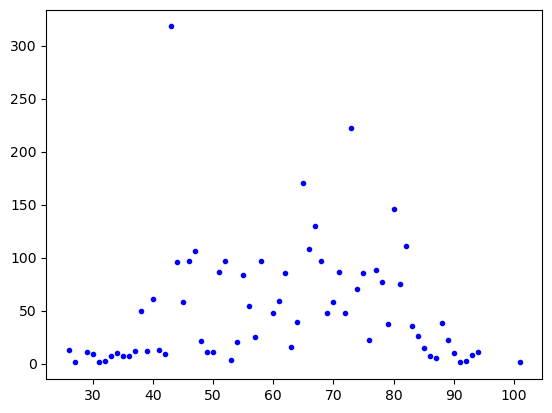

In [58]:
# need to add plot
import matplotlib
import matplotlib.pyplot as plt
import numpy

age=list(age_frequency.keys())
frequency=list(age_frequency.values())
print(age)
print(frequency)
x=numpy.array(age[1:]) # not taking the "None" key by starting at position 1
y=numpy.array(frequency[1:]) # not taking the "None" frequency by starting at position 1
print(x)
print(y)
#fig,ax=plt.subplots()
#ax.plot(x,y)
#plt.scatter(x,y)
plt.plot(x,y,'.b-',linestyle='None')
plt.show()
#run this box again if figure does not appear